# Monge gap

In [1]:
import dataclasses
from collections.abc import Iterator, Mapping
from types import MappingProxyType
from typing import Any, Dict, Literal, Optional, Tuple, Union

import jax
import jax.numpy as jnp
import sklearn.datasets

import optax
from flax import linen as nn

from matplotlib import pyplot as plt

from ott import datasets
from ott.geometry import costs, pointcloud
from ott.neural import losses, models
from ott.neural.solvers import map_estimator
from ott.solvers.linear import acceleration
from ott.tools import sinkhorn_divergence

%load_ext autoreload
%autoreload 2

## Data Generation

We generate some simple datasets for this notebook.

In [2]:
@dataclasses.dataclass
class SklearnDistribution:
    """A class to define toy probability 2-dimensional distributions.

    Produces rotated ``moons`` and ``s_curve`` sklearn datasets, using
    ``theta_rotation``.
    """

    name: Literal["moon", "s_curve"]
    theta_rotation: float = 0.0
    mean: Optional[jnp.ndarray] = None
    noise: float = 0.01
    scale: float = 1.0
    batch_size: int = 1024
    rng: Optional[jax.Array] = None

    def __iter__(self) -> Iterator[jnp.ndarray]:
        """Random sample generator from Gaussian mixture.

        Returns:
        A generator of samples from the Gaussian mixture.
        """
        return self._create_sample_generators()

    def _create_sample_generators(self) -> Iterator[jnp.ndarray]:
        rng = jax.random.PRNGKey(0) if self.rng is None else self.rng

        # define rotation matrix tp rotate samples
        rotation = jnp.array(
            [
                [jnp.cos(self.theta_rotation), -jnp.sin(self.theta_rotation)],
                [jnp.sin(self.theta_rotation), jnp.cos(self.theta_rotation)],
            ]
        )
        while True:
            rng, _ = jax.random.split(rng)
            seed = jax.random.randint(rng, [], minval=0, maxval=1e5).item()
            if self.name == "moon":
                samples, _ = sklearn.datasets.make_moons(
                    n_samples=(self.batch_size, 0),
                    random_state=seed,
                    noise=self.noise,
                )
            elif self.name == "s_curve":
                x, _ = sklearn.datasets.make_s_curve(
                    n_samples=self.batch_size,
                    random_state=seed,
                    noise=self.noise,
                )
                samples = x[:, [2, 0]]
            else:
                raise NotImplementedError(
                    f"SklearnDistribution `{self.name}` not implemented."
                )

            samples = jnp.asarray(samples, dtype=jnp.float32)
            samples = jnp.squeeze(jnp.matmul(rotation[None, :], samples.T).T)
            mean = jnp.zeros(2) if self.mean is None else self.mean
            samples = mean + self.scale * samples
            yield samples


def create_samplers(
    source_kwargs: Mapping[str, Any] = MappingProxyType({}),
    target_kwargs: Mapping[str, Any] = MappingProxyType({}),
    train_batch_size: int = 256,
    valid_batch_size: int = 256,
    rng: Optional[jax.Array] = None,
) -> tuple[datasets.Dataset, datasets.Dataset, int]:
    """Samplers from ``SklearnDistribution``."""
    rng = jax.random.PRNGKey(0) if rng is None else rng
    rng1, rng2, rng3, rng4 = jax.random.split(rng, 4)
    train_dataset = datasets.Dataset(
        source_iter=iter(
            SklearnDistribution(
                rng=rng1, batch_size=train_batch_size, **source_kwargs
            )
        ),
        target_iter=iter(
            SklearnDistribution(
                rng=rng2, batch_size=train_batch_size, **target_kwargs
            )
        ),
    )
    valid_dataset = datasets.Dataset(
        source_iter=iter(
            SklearnDistribution(
                rng=rng3, batch_size=valid_batch_size, **source_kwargs
            )
        ),
        target_iter=iter(
            SklearnDistribution(
                rng=rng4, batch_size=valid_batch_size, **target_kwargs
            )
        ),
    )
    dim_data = 2
    return train_dataset, valid_dataset, dim_data

We also define a plot function to display results

In [3]:
def plot_samples(
    batch: dict[str, Any],
    num_points: Optional[int] = None,
    title: Optional[str] = None,
    figsize: tuple[int, int] = (8, 6),
    rng: Optional[jax.Array] = None,
):
    """Plot samples from the source and target measures.

    If source samples mapped by the fitted map are provided in ``batch``,
    the function plots these predictions as well.
    """
    rng = jax.random.PRNGKey(0) if rng is None else rng
    fig, ax = plt.subplots(figsize=figsize)
    if num_points is None:
        subsample = jnp.arange(len(batch["source"]))
    else:
        subsample = jax.random.choice(
            rng, a=len(batch["source"]), shape=(num_points,)
        )
    ax.scatter(
        batch["source"][subsample, 0],
        batch["source"][subsample, 1],
        label="source",
        c="b",
        edgecolors="k",
        s=300,
        alpha=0.8,
    )
    ax.scatter(
        batch["target"][subsample, 0],
        batch["target"][subsample, 1],
        label="target",
        c="r",
        edgecolors="k",
        marker="X",
        s=300,
        alpha=0.6,
    )
    bool_plot_pred = "mapped_source" in batch
    if "mapped_source" in batch:
        ax.scatter(
            batch["mapped_source"][subsample, 0],
            batch["mapped_source"][subsample, 1],
            label="push-forward",
            c="orange",
            edgecolors="k",
            marker="X",
            s=300,
            alpha=0.8,
        )
        z = batch["mapped_source"] - batch["source"]
        ax.quiver(
            batch["source"][subsample, 0],
            batch["source"][subsample, 1],
            z[subsample, 0],
            z[subsample, 1],
            angles="xy",
            scale_units="xy",
            scale=1.0,
            width=0.003,
            headwidth=10,
            headlength=10,
            color="dodgerblue",
            edgecolor="k",
            alpha=0.5,
        )
    if title is None:
        title = (
            r"Fitted map $\hat{T}_\theta$"
            if bool_plot_pred
            else r"Source and Target Measures"
        )
    ax.set_title(title, fontsize=20, y=1.01)
    ax.tick_params(axis="both", which="major", labelsize=16)
    ax.legend(fontsize=16)
    fig.tight_layout()
    plt.show()

We can now use these tools to create the task

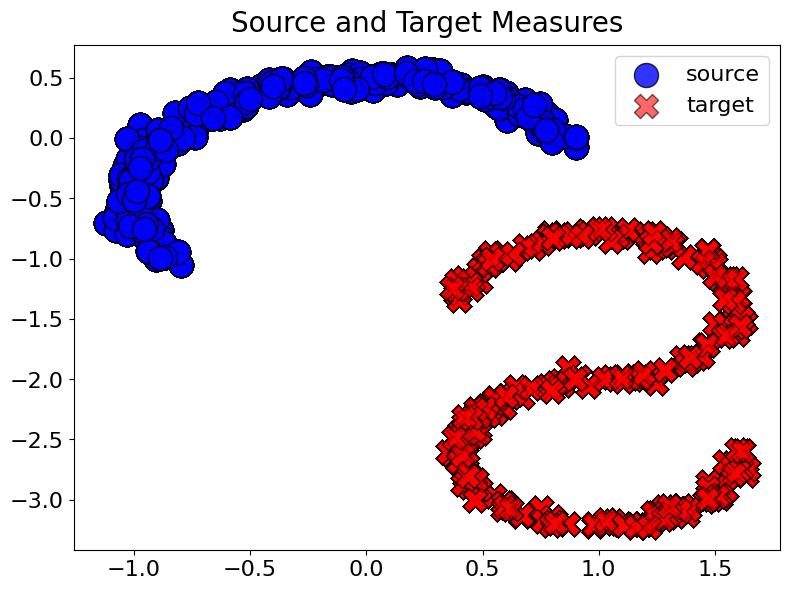

In [4]:
train_dataset, valid_dataset, dim_data = create_samplers(
    source_kwargs={
        "name": "moon",
        "theta_rotation": jnp.pi / 6,
        "mean": jnp.array([0.0, -0.5]),
        "noise": 0.05,
    },
    target_kwargs={
        "name": "s_curve",
        "scale": 0.6,
        "mean": jnp.array([1.0, -2.0]),
        "theta_rotation": jnp.pi / 2,
        "noise": 0.05,
    },
)

batch = {}
batch["source"] = next(train_dataset.source_iter)
batch["target"] = next(train_dataset.target_iter)
plot_samples(batch=batch, num_points=10000)

## Learning Maps: Losses, Hyperparameters and Training Loop

The `fit_map` function below implements the following minimization:

$$
\min_{T:\mathbb{R}^d \rightarrow \mathbb{R}^d} \Delta(T\sharp \mu, \nu) + \lambda_\mathrm{MG} \mathcal{M}_\mu^c(T)
$$
For all fittings, we use $\Delta = S_{\varepsilon, \ell_2^2}$, the {func}`~ott.tools.sinkhorn_divergence.sinkhorn_divergence` with the {class}`squared-Euclidean cost <ott.geometry.costs.SqEuclidean>`
The function considers a ground cost function `cost_fn` (corresponding to $c$), as well as the `epsilon` regularization parameters to compute approximated Wasserstein distances, both for fitting and regularizer.

In [50]:
def fit_map_simple_bilevel(
    cost_fn,
    relative_epsilon_fitting=1e-1,
    relative_epsilon_regularizer=1e-2,
    regularizer_strength=0.1,
    num_train_iters=5000,
    ema=0.5,
    simple=False,
):
    dim_data = 2
    # define the neural map
    model = models.MLP(
        dim_hidden=[32, 64, 32], is_potential=False, act_fn=nn.gelu
    )

    # define the optimizer to learn the neural map
    lr = 1e-2
    optimizer = optax.sgd(learning_rate=lr)
    ema *= lr
    # Compute an order of magnitude for epsilon fitting
    y = next(train_dataset.target_iter)
    epsilon_fitting_scale = pointcloud.PointCloud(y).mean_cost_matrix
    epsilon_fitting = relative_epsilon_fitting * epsilon_fitting_scale
    print("Selected `epsilon_fitting`:", epsilon_fitting)

    @jax.jit
    def fitting_loss(x, y):
        out = sinkhorn_divergence.sinkhorn_divergence(
            pointcloud.PointCloud, x, y, epsilon=epsilon_fitting, static_b=True
        )
        return out.divergence, out.n_iters

    # Compute an order of magnitude for epsilon regularizer
    x = next(train_dataset.source_iter)
    epsilon_regularizer_scale = pointcloud.PointCloud(x, y).mean_cost_matrix
    epsilon_regularizer = (
        relative_epsilon_regularizer * epsilon_regularizer_scale
    )
    print("Selected `epsilon_regularizer`:", epsilon_regularizer)

    def regularizer(x, y):
        gap, out = losses.monge_gap_from_samples(
            x,
            y,
            cost_fn=cost_fn,
            epsilon=epsilon_regularizer,
            return_output=True,
        )
        return gap, out.n_iters

    # define solver
    solver = map_estimator.MapEstimator(
        dim_data=dim_data,
        fitting_loss=fitting_loss,
        regularizer=regularizer,
        model=model,
        optimizer=optimizer,
        regularizer_strength=regularizer_strength,
        num_train_iters=num_train_iters,
        logging=True,
        valid_freq=25,
        ema=ema,
        simple=simple,
    )

    return solver.train_map_estimator(
        trainloader_source=train_dataset.source_iter,
        trainloader_target=train_dataset.target_iter,
        validloader_source=valid_dataset.source_iter,
        validloader_target=valid_dataset.target_iter,
    )


def plot_fit_map(title_prefix, neural_state, logs, num_points=30):
    plt.figure(figsize=(9, 3))
    plt.plot(logs["eval"]["total_loss"], label="total loss")
    reg = logs["eval"].get("regularizer")
    if reg[0] > 0.0:
        plt.plot(reg, label="regularizer")
        plt.plot(logs["eval"].get("fitting_loss"), label="fitting loss")

    plt.title("Evaluation error")
    plt.xlabel("Validation iteration")
    plt.legend()
    plt.loglog()

    # plot the fitted map
    batch["mapped_source"] = neural_state.apply_fn(
        {"params": neural_state.params},
        batch["source"][:, :num_points],
    )
    plot_samples(
        batch=batch,
        num_points=num_points,
        title=r"Fitted map $\hat{T}_\theta$, " + title_prefix,
    )
    sink_its = logs["eval"]["log_fitting"]
    print(
        "Avg # of Sinkhorn iterations for fitting loss",
        10
        * jnp.mean(jnp.array([sink_its[i][0] for i in range(len(sink_its))])),
    )
    if reg[0] > 0.0:
        sink_its = logs["eval"]["log_regularizer"]
        print(
            "Avg # of Sinkhorn iterations for regularizer",
            10
            * jnp.mean(jnp.array([sink_its[i] for i in range(len(sink_its))])),
        )

### Monge gap with $c = \ell_2$

For the Monge gap with $c = \ell_2$, we obtain a "needle" alignment (without crossing lines) because $c$ is a distance: this is known as the Monge Mather shortening principle (see e.g. {cite}`villani:09`).

Selected `epsilon_fitting`: 0.18471065
Selected `epsilon_regularizer`: 0.07392495


100%|██████████| 5000/5000 [04:40<00:00, 17.80it/s, fitting_loss: 0.1986, regularizer: 0.7765 ,total: 1.7517]


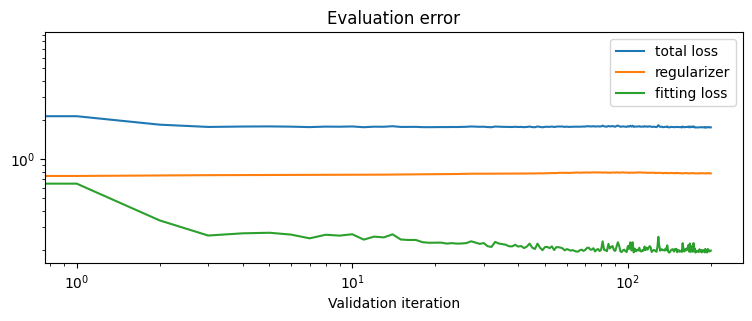

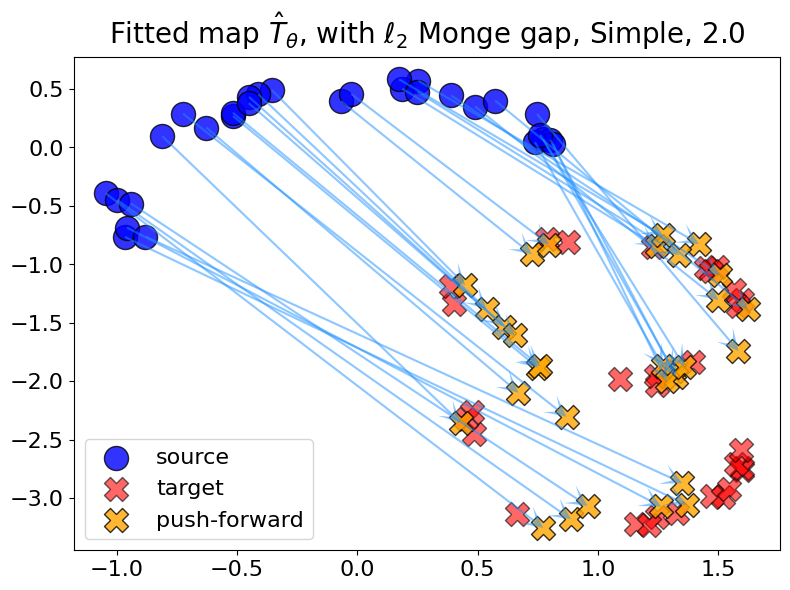

Avg # of Sinkhorn iterations for fitting loss 535.32336
Avg # of Sinkhorn iterations for regularizer 206.96516
Selected `epsilon_fitting`: 0.1773628
Selected `epsilon_regularizer`: 0.07480676


100%|██████████| 5000/5000 [06:40<00:00, 12.47it/s, fitting_loss: 0.2102, regularizer: 0.7688 ,total: 1.7478]  


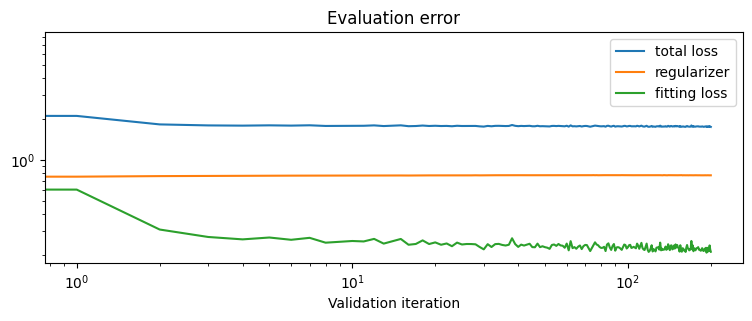

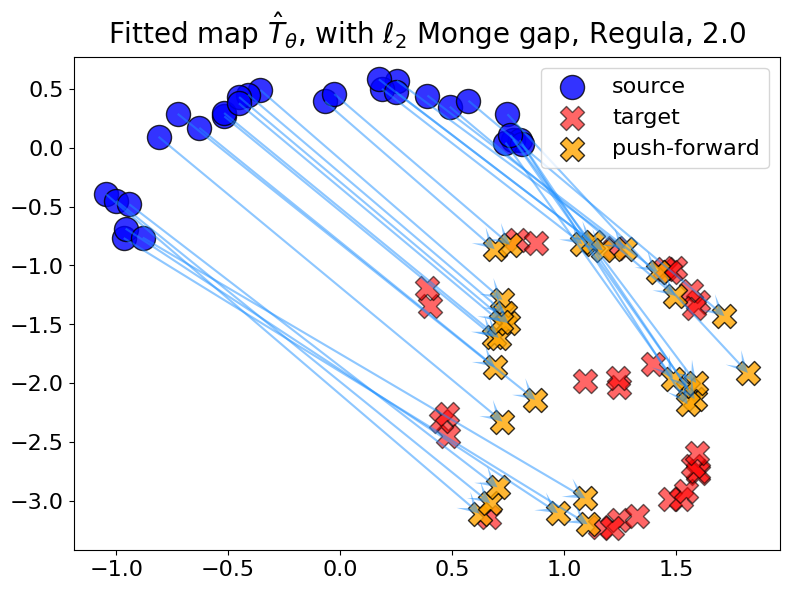

Avg # of Sinkhorn iterations for fitting loss 468.65668
Avg # of Sinkhorn iterations for regularizer 206.96516
Selected `epsilon_fitting`: 0.18124133
Selected `epsilon_regularizer`: 0.07518053


100%|██████████| 5000/5000 [06:22<00:00, 13.09it/s, fitting_loss: 0.2071, regularizer: 0.7765 ,total: 4.0897]


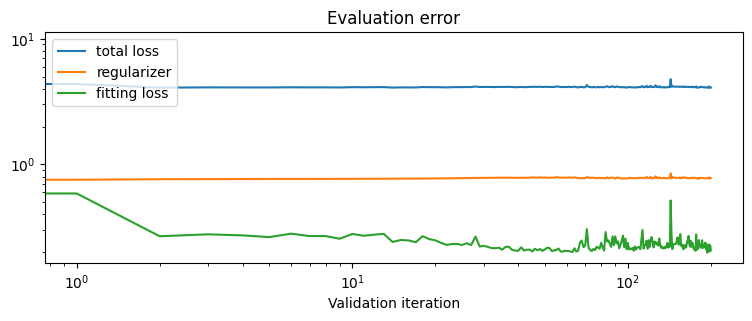

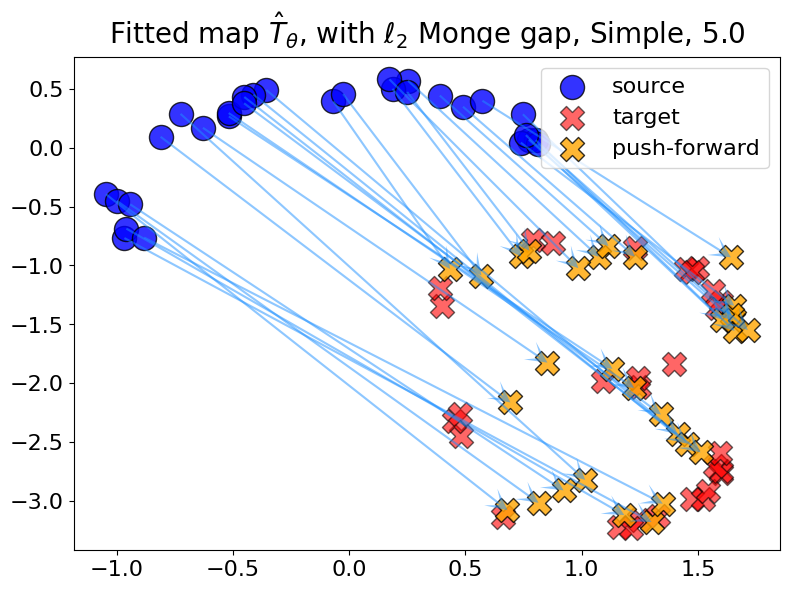

Avg # of Sinkhorn iterations for fitting loss 496.0199
Avg # of Sinkhorn iterations for regularizer 199.00497
Selected `epsilon_fitting`: 0.1752328
Selected `epsilon_regularizer`: 0.071976006


100%|██████████| 5000/5000 [06:50<00:00, 12.18it/s, fitting_loss: 0.2274, regularizer: 0.7287 ,total: 3.8708]


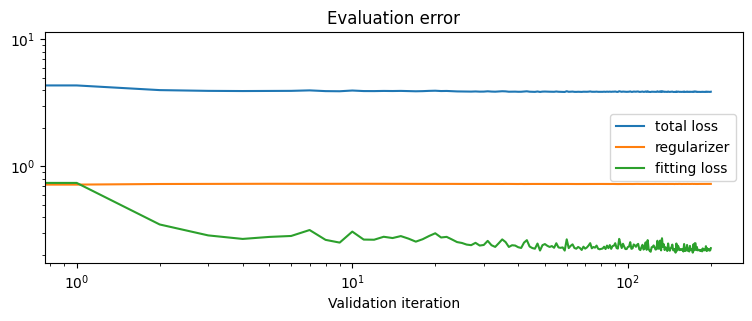

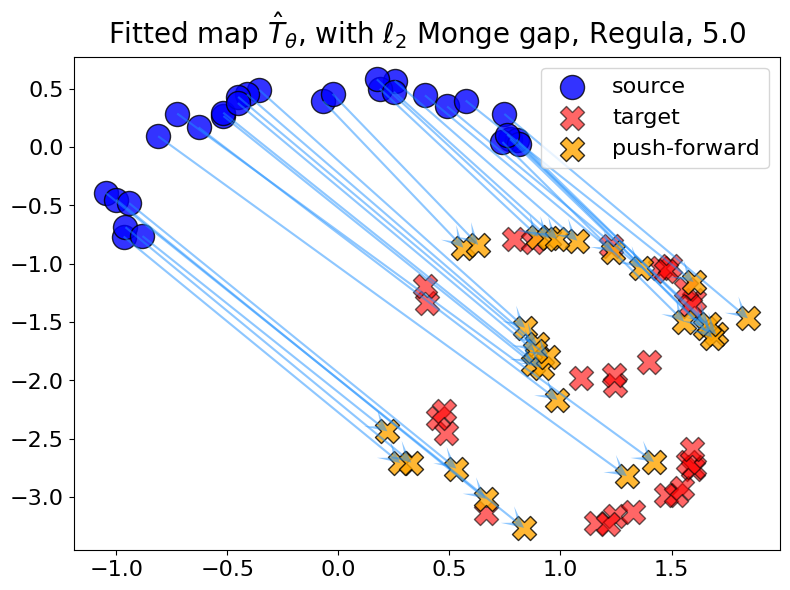

Avg # of Sinkhorn iterations for fitting loss 567.1642
Avg # of Sinkhorn iterations for regularizer 206.96516
Selected `epsilon_fitting`: 0.17251126
Selected `epsilon_regularizer`: 0.07315706


100%|██████████| 5000/5000 [06:44<00:00, 12.37it/s, fitting_loss: 0.2003, regularizer: 0.7502 ,total: 7.7020]


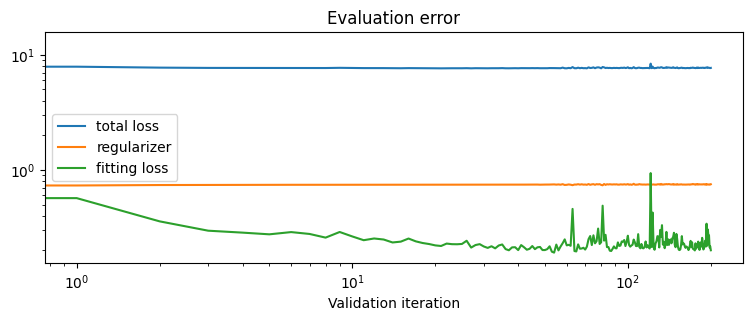

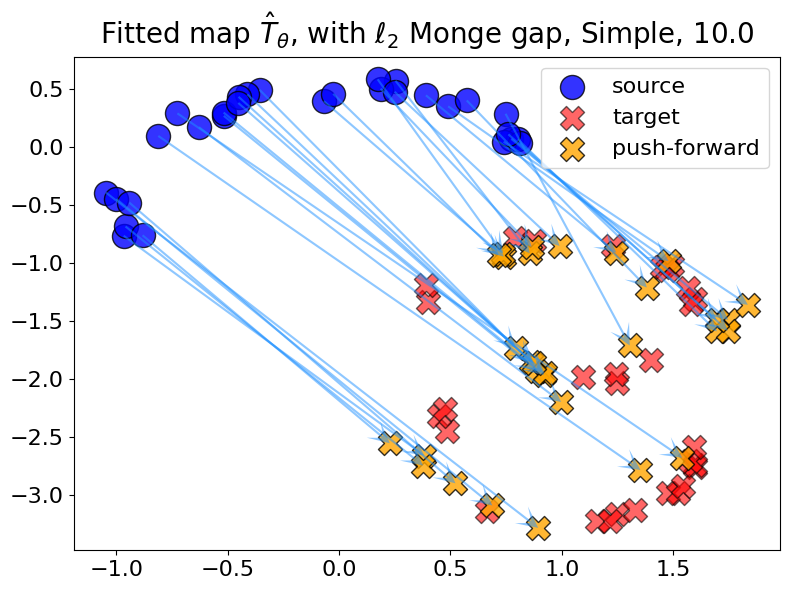

Avg # of Sinkhorn iterations for fitting loss 548.7562
Avg # of Sinkhorn iterations for regularizer 202.98508
Selected `epsilon_fitting`: 0.15221962
Selected `epsilon_regularizer`: 0.07577419


100%|██████████| 5000/5000 [08:07<00:00, 10.25it/s, fitting_loss: 0.2766, regularizer: 0.7648 ,total: 7.9250]


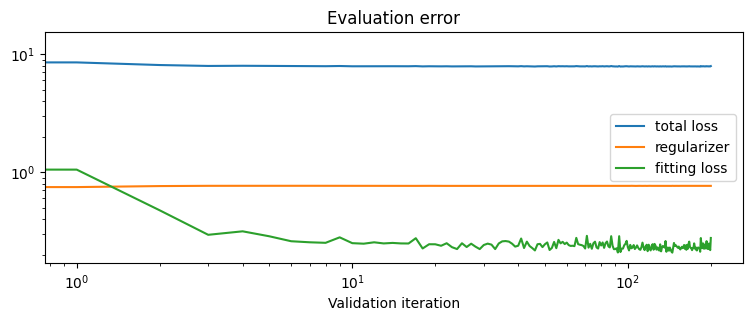

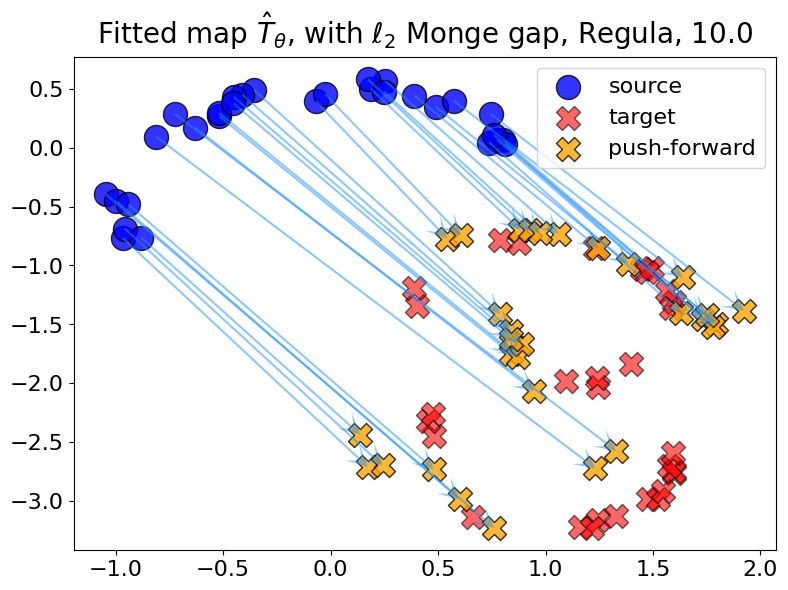

Avg # of Sinkhorn iterations for fitting loss 733.33325
Avg # of Sinkhorn iterations for regularizer 206.46765
Selected `epsilon_fitting`: 0.17113142
Selected `epsilon_regularizer`: 0.076967716


100%|██████████| 5000/5000 [07:54<00:00, 10.55it/s, fitting_loss: 1.0355, regularizer: 0.7898 ,total: 40.5266]  


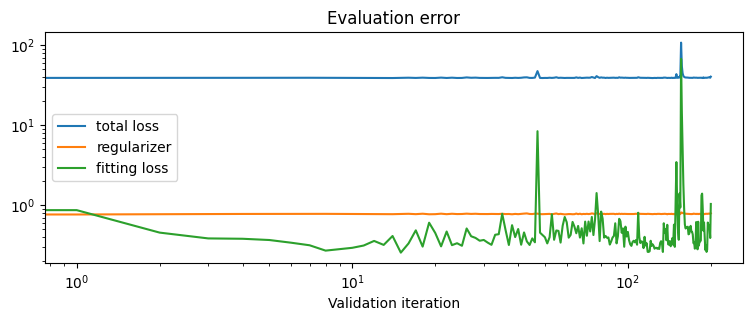

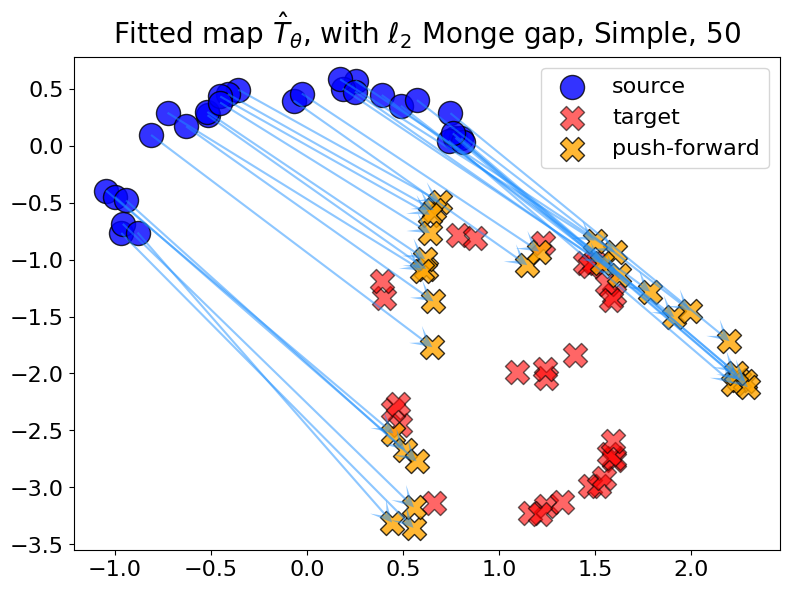

Avg # of Sinkhorn iterations for fitting loss 680.0995
Avg # of Sinkhorn iterations for regularizer 237.31342
Selected `epsilon_fitting`: 0.17169999
Selected `epsilon_regularizer`: 0.07306591


100%|██████████| 5000/5000 [20:14<00:00,  4.12it/s, fitting_loss: 2.4685, regularizer: 0.6748 ,total: 36.2068]   


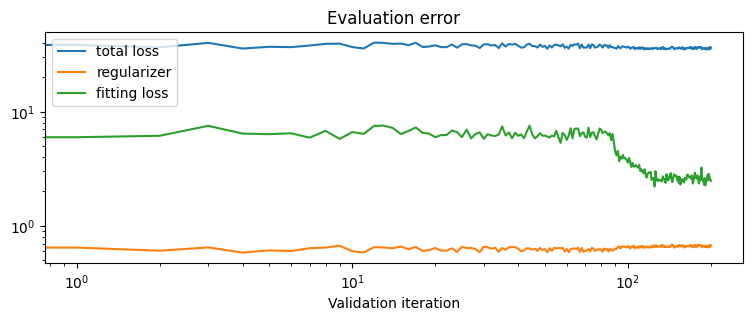

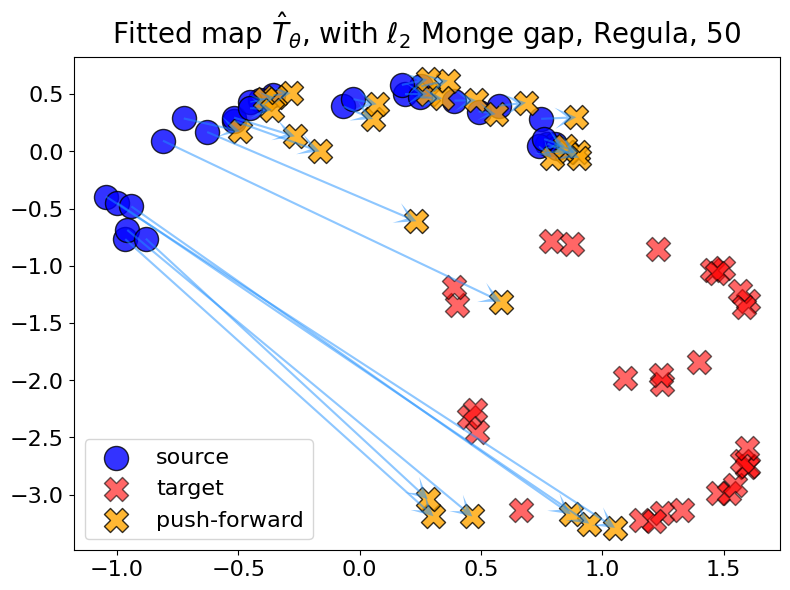

Avg # of Sinkhorn iterations for fitting loss 1107.9602
Avg # of Sinkhorn iterations for regularizer 1177.1144
Selected `epsilon_fitting`: 0.1772441
Selected `epsilon_regularizer`: 0.07101499


100%|██████████| 5000/5000 [05:03<00:00, 16.49it/s, fitting_loss: nan, regularizer: nan ,total: nan]            


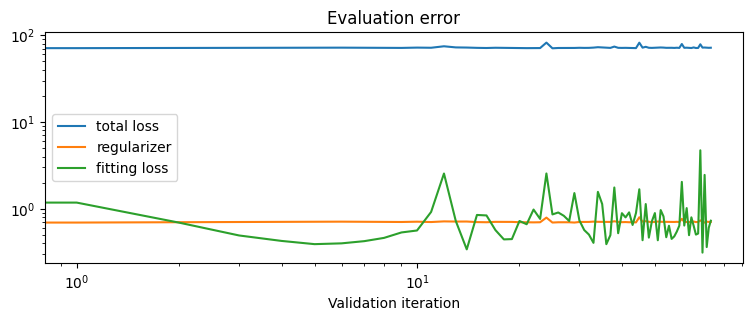

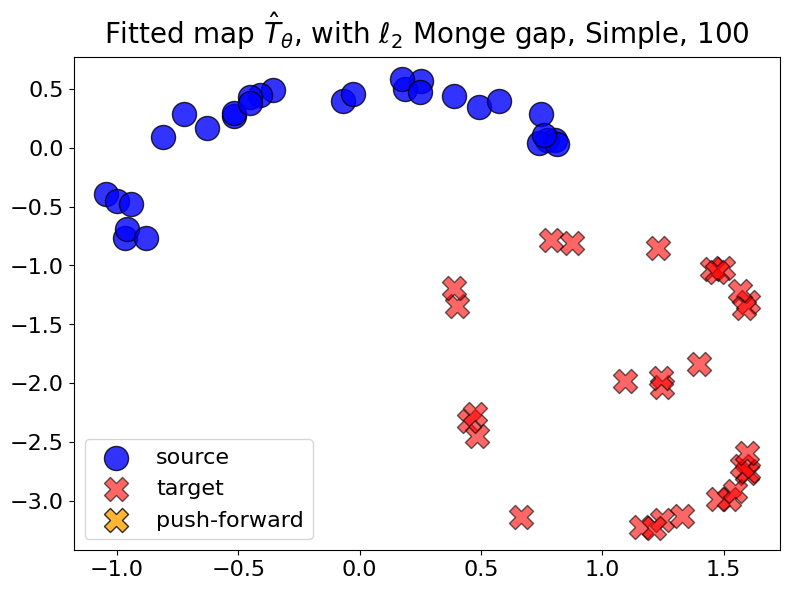

Avg # of Sinkhorn iterations for fitting loss 332.83582
Avg # of Sinkhorn iterations for regularizer 178.60696
Selected `epsilon_fitting`: 0.16313186
Selected `epsilon_regularizer`: 0.07432699


100%|██████████| 5000/5000 [17:04<00:00,  4.88it/s, fitting_loss: 5.8304, regularizer: 0.6581 ,total: 71.6416]


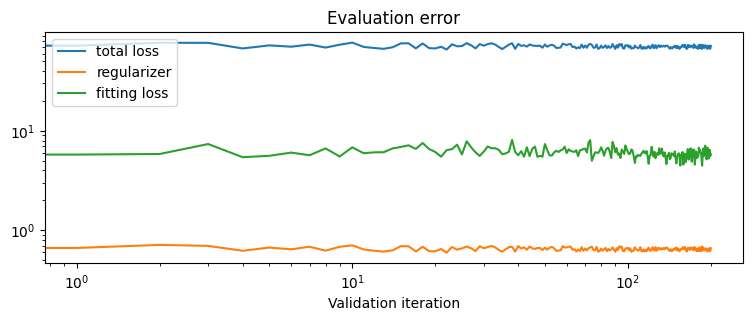

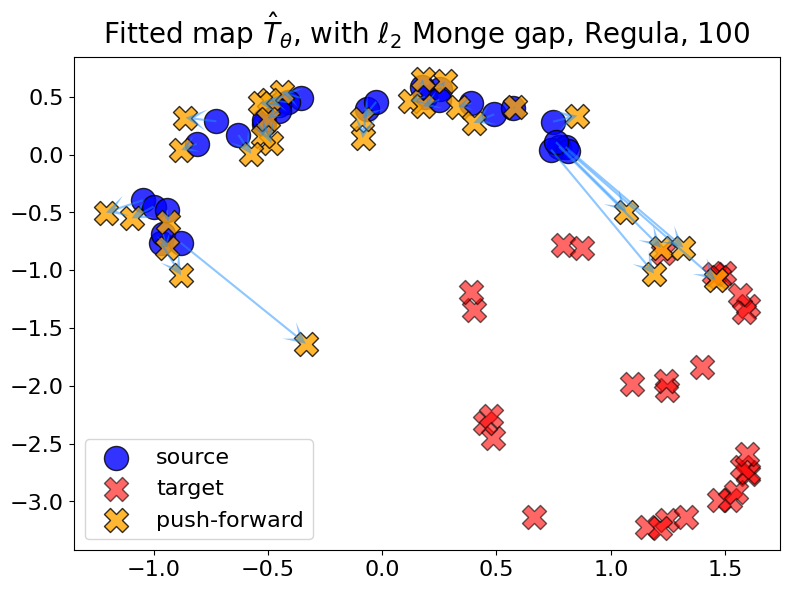

Avg # of Sinkhorn iterations for fitting loss 638.80597
Avg # of Sinkhorn iterations for regularizer 1502.9851


In [53]:
regularizer_strengths = [2.0, 5.0, 10.0, 50, 100]

for regularizer_strength in regularizer_strengths:
    out_nn_l2, logs_l2 = fit_map_simple_bilevel(
        costs.Euclidean(),
        regularizer_strength=regularizer_strength,
        simple=True,
    )
    plot_fit_map(
        rf"with $\ell_2$ Monge gap, Simple, " + str(regularizer_strength),
        out_nn_l2,
        logs_l2,
    )
    out_nn_l2, logs_l2 = fit_map_simple_bilevel(
        costs.Euclidean(),
        regularizer_strength=regularizer_strength,
        simple=False,
    )
    plot_fit_map(
        rf"with $\ell_2$ Monge gap, Regula, " + str(regularizer_strength),
        out_nn_l2,
        logs_l2,
    )

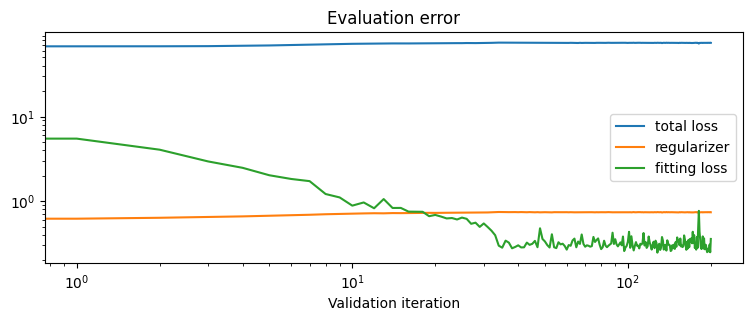

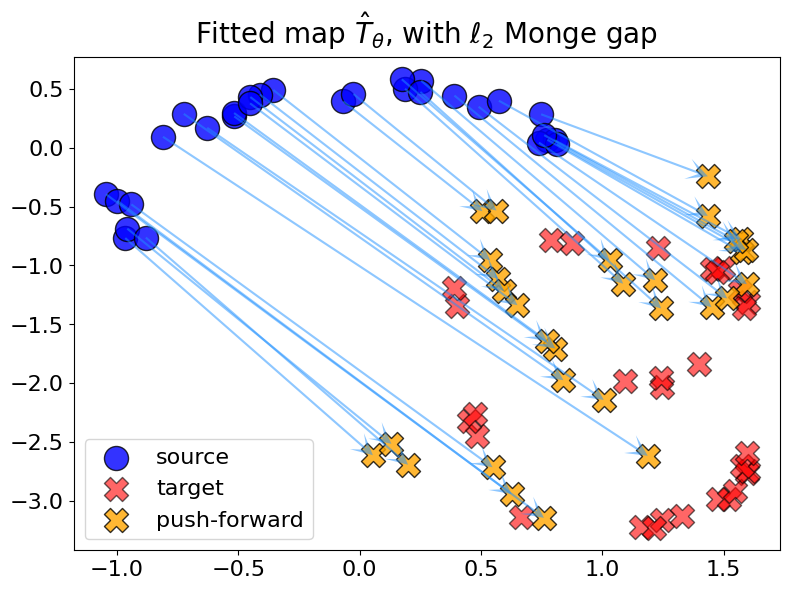

Avg # of Sinkhorn iterations for fitting loss 801.99005
Avg # of Sinkhorn iterations for regularizer 215.42288


In [23]:
plot_fit_map(rf"with $\ell_2$ Monge gap", out_nn_l2, logs_l2)

Selected `epsilon_fitting`: 0.17932491
Selected `epsilon_regularizer`: 0.07311599


100%|██████████| 1000/1000 [01:00<00:00, 16.50it/s, fitting_loss: 0.2708, regularizer: 0.7390 ,total: 15.0506]


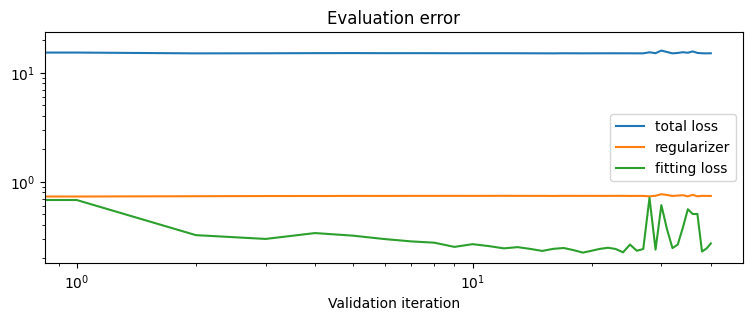

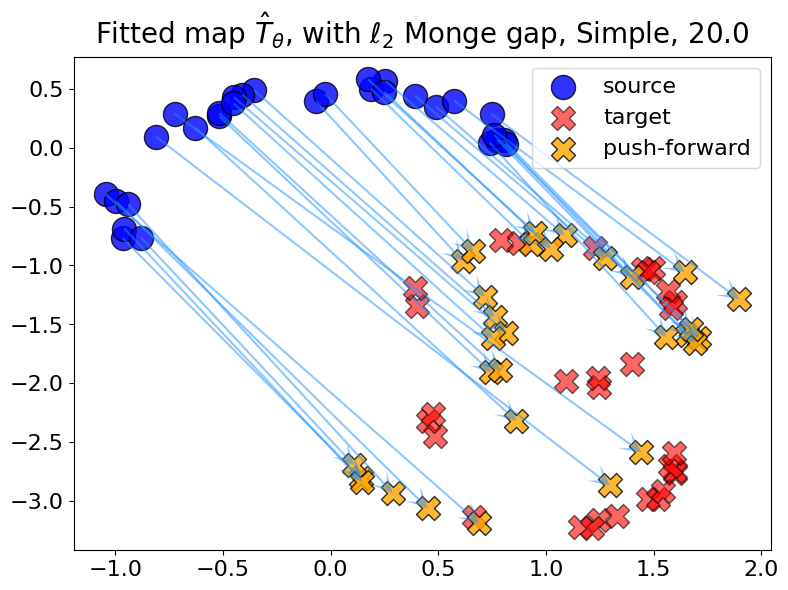

Avg # of Sinkhorn iterations for fitting loss 604.87805
Avg # of Sinkhorn iterations for regularizer 243.90244
Selected `epsilon_fitting`: 0.17153332
Selected `epsilon_regularizer`: 0.07711348


100%|██████████| 1000/1000 [01:48<00:00,  9.22it/s, fitting_loss: 0.8875, regularizer: 0.7496 ,total: 15.8802]


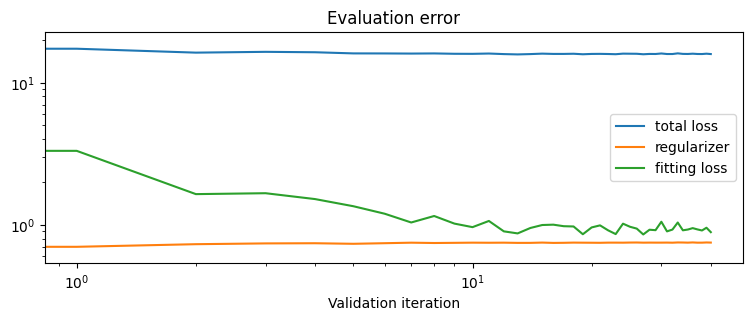

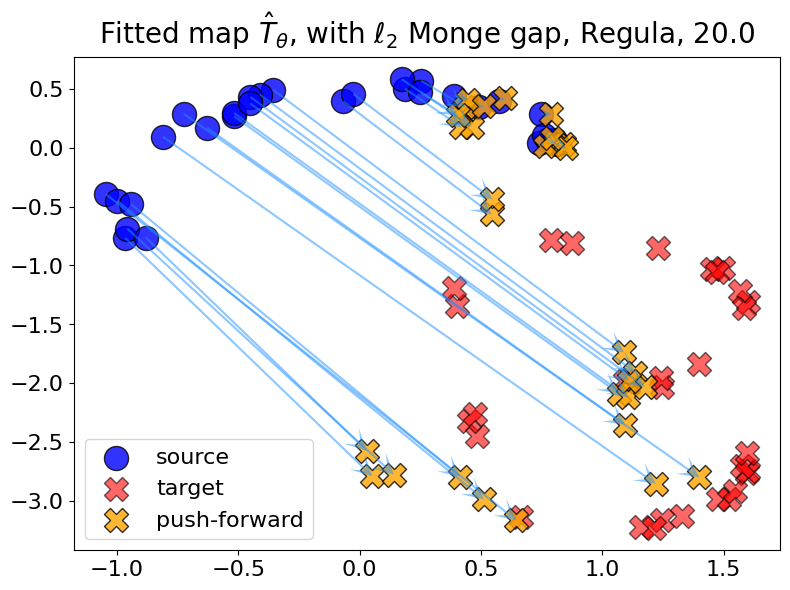

Avg # of Sinkhorn iterations for fitting loss 1214.634
Avg # of Sinkhorn iterations for regularizer 334.14636
Selected `epsilon_fitting`: 0.17626598
Selected `epsilon_regularizer`: 0.07699837


100%|██████████| 1000/1000 [01:08<00:00, 14.57it/s, fitting_loss: 0.5381, regularizer: 0.7712 ,total: 39.0992]


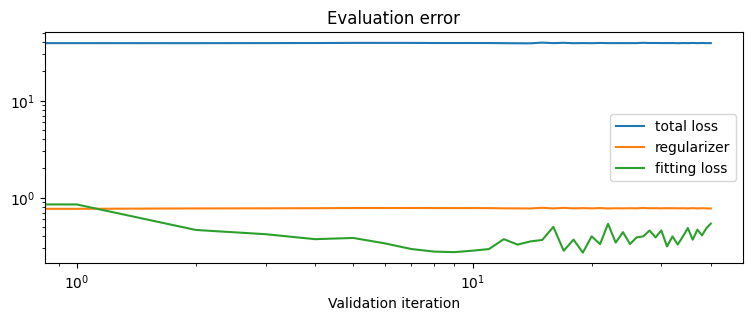

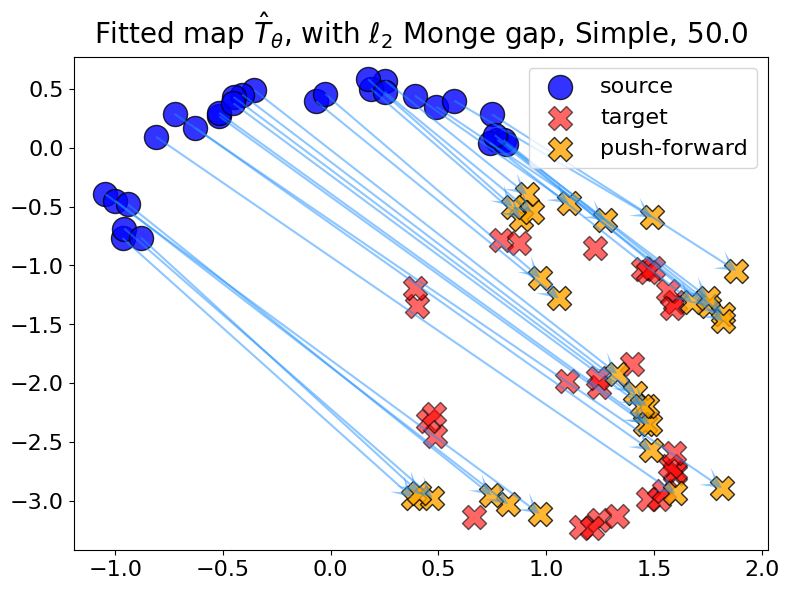

Avg # of Sinkhorn iterations for fitting loss 670.7317
Avg # of Sinkhorn iterations for regularizer 246.34146
Selected `epsilon_fitting`: 0.17397304
Selected `epsilon_regularizer`: 0.0751559


100%|██████████| 1000/1000 [02:23<00:00,  6.97it/s, fitting_loss: 2.6831, regularizer: 0.6902 ,total: 37.1943]


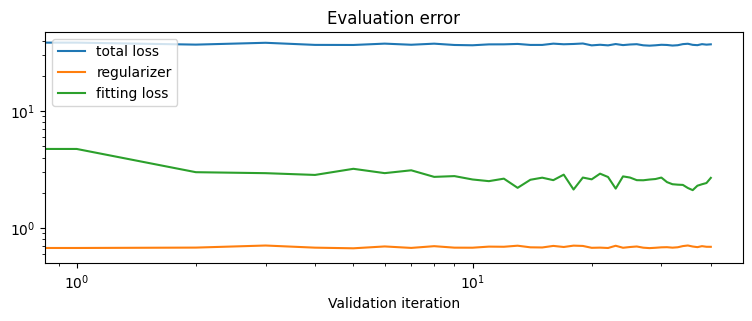

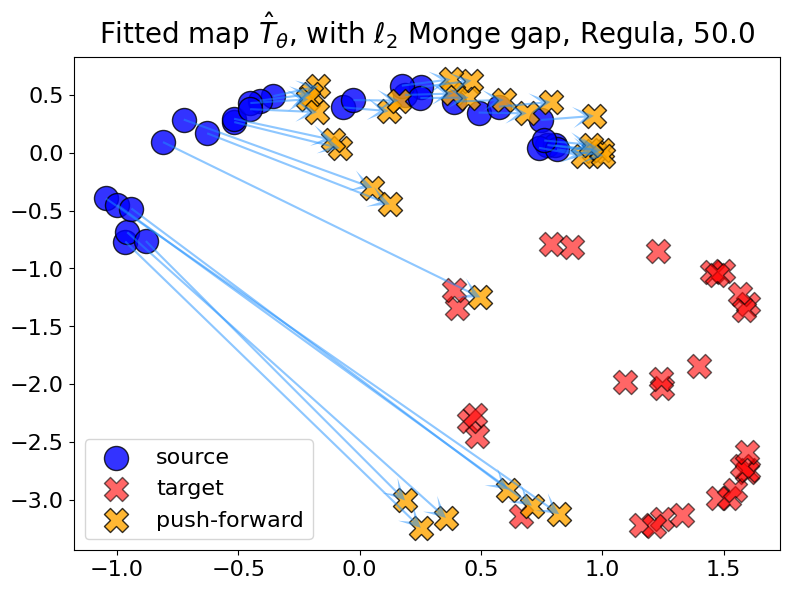

Avg # of Sinkhorn iterations for fitting loss 1463.4146
Avg # of Sinkhorn iterations for regularizer 634.1463
Selected `epsilon_fitting`: 0.17226145
Selected `epsilon_regularizer`: 0.07384258


100%|██████████| 1000/1000 [01:14<00:00, 13.45it/s, fitting_loss: 1.4684, regularizer: 0.7363 ,total: 75.0943]


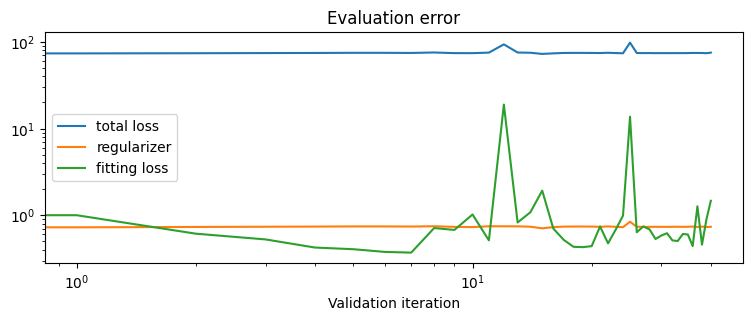

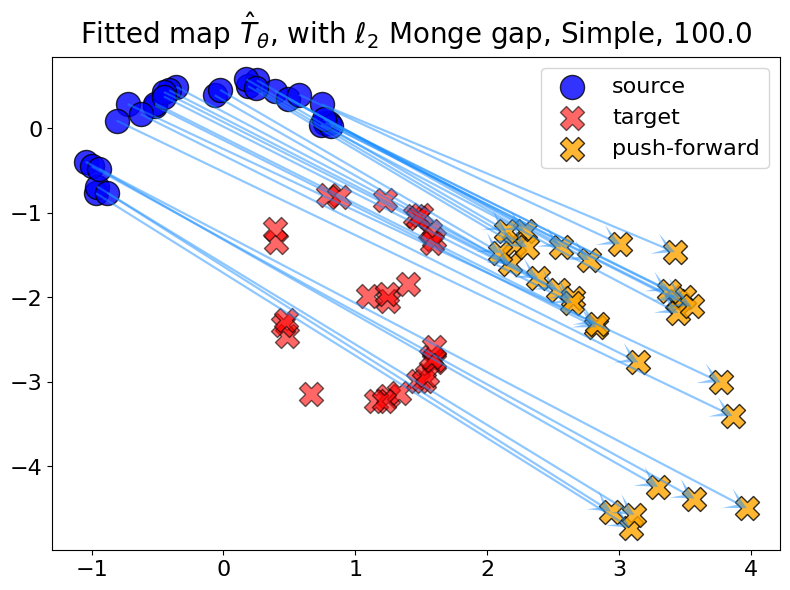

Avg # of Sinkhorn iterations for fitting loss 758.5365
Avg # of Sinkhorn iterations for regularizer 295.12195
Selected `epsilon_fitting`: 0.17902082
Selected `epsilon_regularizer`: 0.075063154


100%|██████████| 1000/1000 [02:15<00:00,  7.39it/s, fitting_loss: 5.6622, regularizer: 0.6709 ,total: 72.7522]


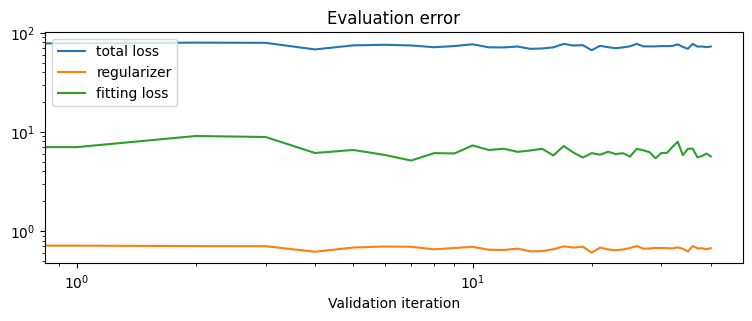

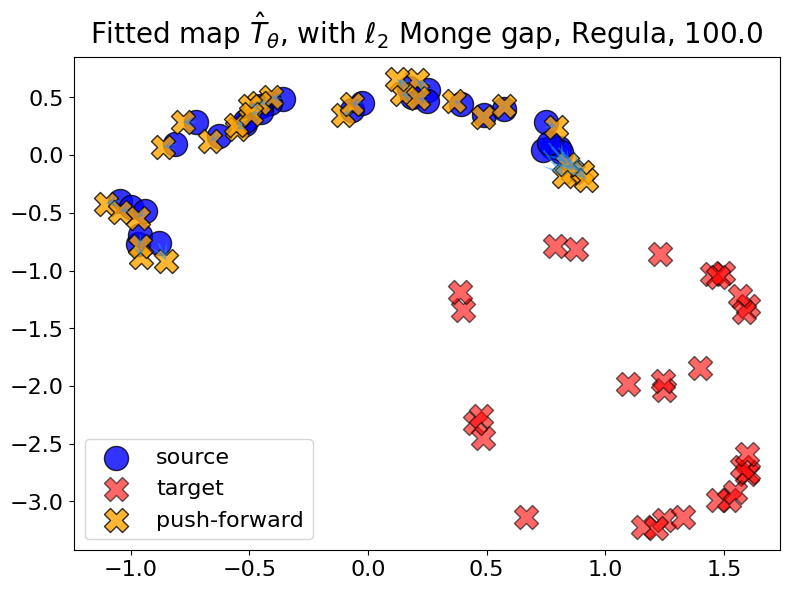

Avg # of Sinkhorn iterations for fitting loss 492.68292
Avg # of Sinkhorn iterations for regularizer 1541.4634


In [52]:
regularizer_strengths = [20.0, 50.0, 100.0]

for regularizer_strength in regularizer_strengths:
    out_nn_l2, logs_l2 = fit_map_simple_bilevel(
        costs.Euclidean(),
        regularizer_strength=regularizer_strength,
        num_train_iters=1000,
        simple=True,
    )
    plot_fit_map(
        rf"with $\ell_2$ Monge gap, Simple, " + str(regularizer_strength),
        out_nn_l2,
        logs_l2,
    )
    out_nn_l2, logs_l2 = fit_map_simple_bilevel(
        costs.Euclidean(),
        regularizer_strength=regularizer_strength,
        num_train_iters=1000,
        simple=False,
    )
    plot_fit_map(
        rf"with $\ell_2$ Monge gap, Regula, " + str(regularizer_strength),
        out_nn_l2,
        logs_l2,
    )

### Monge gap with $c = \ell_2^2$

For $c = \ell_2^2$, we observe crossings when the sum of the squared diagonals of the quadrilateral induced by 4 points $(x_1, x_2, T(x_1), T(x_2))$ is lower than the sum of the squared sides. 

In [ ]:
out_nn_l22, logs_l22 = fit_map(costs.SqEuclidean(), regularizer_strength=0.1)

Selected `epsilon_fitting`: 0.16706443
Selected `epsilon_regularizer`: 0.074911


100%|██████████| 5000/5000 [01:23<00:00, 60.16it/s, fitting_loss: 0.1948, regularizer: 0.6860 ,total: 0.2634]


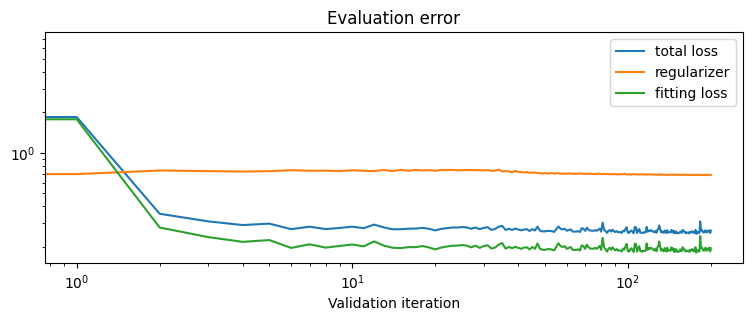

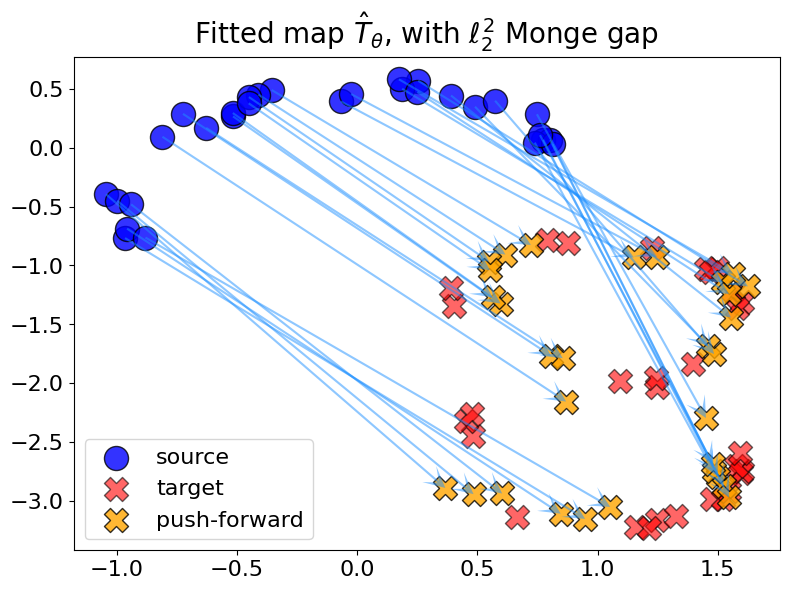

Avg # of Sinkhorn iterations for fitting loss 546.2687
Avg # of Sinkhorn iterations for regularizer 1223.8805


In [ ]:
plot_fit_map(rf"with $\ell_2^2$ Monge gap", out_nn_l22, logs_l22)